<a href="https://colab.research.google.com/github/walkerjian/dev/blob/main/Simulating_Electricity_Prices_with_Mean_Reversion_and_Jump_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Simulating Electricity Prices with Mean-Reversion and Jump-Diffusion
This example shows how to simulate electricity prices using a mean-reverting model with seasonality and a jump component. The model is calibrated under the real-world probability using historical electricity prices. The market price of risk is obtained from futures prices. A risk-neutral Monte Carlo simulation is conducted using the calibrated model and the market price of risk. The simulation results are used to price a Bermudan option with electricity prices as the underlying.

##Overview of the Model
Electricity prices exhibit jumps in prices at periods of high demand when additional, less efficient electricity generation methods, are brought on-line to provide a sufficient supply of electricity. In addition, they have a prominent seasonal component, along with reversion to mean levels. Therefore, these characteristics should be incorporated into a model of electricity prices [2].
In this example, electricity price is modeled as:
$$
\log \left(P_t\right)=f(t)+X_t
$$
where $P_t$ is the spot price of electricity. The logarithm of electricity price is modeled with two components: $f(t)$ and $X_t$. The component $f(t)$ is the deterministic seasonal part of the model, and $X_t$ is the stochastic part of the model. Trigonometric functions are used to model $f(t)$ as follows [3]:
$$
f(t)=s_1 \sin (2 \pi t)+s_2 \cos (2 \pi t)+s_3 \sin (4 \pi t)+s_4 \cos (4 \pi t)+s_5
$$
where $s_i, i=1, \ldots, 5$ are constant parameters, and $t$ is the annualized time factors. The stochastic component $X_t$ is modeled as an Ornstein-Uhlenbeck process (mean-reverting) with jumps:
$$
d X_t=\left(\alpha-\kappa X_t\right) d t+\sigma d W_t+J\left(\mu_J, \sigma_J\right) d \Pi(\lambda)
$$

The parameters $\alpha$ and $\kappa$ are the mean-reversion parameters. Parameter $\sigma$ is the volatility, and $W_t$ is a standard Brownian motion. The jump size is $J\left(\mu_J, \sigma_J\right)$, with a normally distributed mean $\mu_J$, and a standard deviation $\sigma_J$. The Poisson process $\Pi(\lambda)$ has a jump intensity of $\lambda$.

##Electricity Prices
Sample electricity prices from January 1, 2010 to November 11, 2013 are loaded and plotted below. Prices contain the electricity prices, and PriceDates contain the dates associated with the prices. The logarithm of the prices and annual time factors are calculated.

```Matlab
% Load the electricity prices and futures prices.
load('electricity_prices.mat');
PriceDates = datetime(PriceDates,'ConvertFrom','datenum');
FutExpiry = datetime(FutExpiry,'ConvertFrom','datenum');
FutValuationDate = datetime(FutValuationDate,'ConvertFrom','datenum');
% Plot the electricity prices.
figure;
plot(PriceDates, Prices);
title('Electricity Prices');
xlabel('Date');
ylabel('Price ($)');
```

```Matlab
% Obtain the log of prices.
logPrices = log(Prices);

% Obtain the annual time factors from dates.
PriceTimes = yearfrac(PriceDates(1), PriceDates);
```
##Calibration
First, the deterministic seasonality part is calibrated using the least squares method. Since the seasonality function is linear with respect to the parameters , the backslash operator (mldivide) is used. After the calibration, the seasonality is removed from the logarithm of price. The logarithm of price and seasonality trends are plotted below. Also, the de-seasonalized logarithm of price is plotted.
```Matlab
% Calibrate parameters for the seasonality model.
seasonMatrix = @(t) [sin(2.*pi.*t) cos(2.*pi.*t) sin(4.*pi.*t) ...
    cos(4.*pi.*t) t ones(size(t, 1), 1)];
C = seasonMatrix(PriceTimes);
seasonParam = C\logPrices;

% Plot the log price and seasonality line.
figure;
subplot(2, 1, 1);
plot(PriceDates, logPrices);
title('log(price) and Seasonality');
xlabel('Date');
ylabel('log(Prices)');
hold on;
plot(PriceDates, C*seasonParam, 'r');
hold off;
legend('log(Price)', 'seasonality');

% Plot de-seasonalized log price
X = logPrices-C*seasonParam;
subplot(2, 1, 2);
plot(PriceDates, X);
title('log(price) with Seasonality Removed');
xlabel('Date');
ylabel('log(Prices)');
```

The second stage is to calibrate the stochastic part. The model for $X_t$ needs to be discretized to conduct the calibration. To discretize, assume that there is a Bernoulli process for the jump events. That is, there is at most one jump per day since this example is calibrating against daily electricity prices. The discretized equation is:
$$
X_t=\alpha \Delta t+\phi X_{t-1}+\sigma \xi
$$
with probability $(1-\lambda \Delta t)$ and,
$$
X_t=\alpha \Delta t+\phi X_{t-1}+\sigma \xi+\mu_J+\sigma_J \xi_J
$$
with probability $\lambda \Delta t$, where $\xi$ and $\xi_J$ are independent standard normal random variables, and $\phi=1-\kappa \Delta t$. The density function of $X_t$ given $X_{t-1}$ is [1,4]:
$$
\begin{gathered}
f\left(X_t \mid X_{t-1}\right)=(\lambda \Delta t) N_1\left(X_t \mid X_{t-1}\right)+(1-\lambda \Delta t) N_2\left(X_t \mid X_{t-1}\right) \\
N_1\left(X_t \mid X_{t-1}\right)=\left(2 \pi\left(\sigma^2+\sigma_J^2\right)\right)^{-\frac{1}{2}} \exp \left(\frac{-\left(X_t-\alpha \Delta t-\phi X_{t-1}-\mu_J\right)^2}{2\left(\sigma^2+\sigma_J^2\right)}\right) \\
N_2\left(X_t \mid X_{t-1}\right)=\left(2 \pi \sigma^2\right)^{-\frac{1}{2}} \exp \left(\frac{-\left(X_t-\alpha \Delta t-\phi X_{t-1}\right)^2}{2 \sigma^2}\right)
\end{gathered}
$$

The parameters $\theta=\left\{\alpha, \phi, \mu_J, \sigma^2, \sigma_J^2, \lambda\right\}$ can be calibrated by minimizing the negative log likelihood function:
$$
\begin{gathered}
\min _\theta-\sum_{t=1}^T \log \left(f\left(X_t \mid X_{t-1}\right)\right) \\
\text { subject to } \phi<1, \sigma^2>0, \sigma_J^2>0,0 \leq \lambda \Delta t \leq 1
\end{gathered}
$$

The first inequality constraint, $\phi<1$, is equivalent to $\kappa>0$. The volatilities $\sigma$ and $\sigma_J$ must be positive. In the last inequality, $\lambda \Delta t$ is between 0 and 1 , because it represents the probability of a jump occurring in $\Delta t$ time. In this example, assume that $\Delta t$ is one day. Therefore, there is at most 365 jumps in one year. The mle function from the Statistics and Machine Learning Toolbox ${ }^{\text {TM }}$ is well suited to solve the above maximum likelihood problem.

```Matlab
% Prices at t, X(t).
Pt = X(2:end);

% Prices at t-1, X(t-1).
Pt_1 = X(1:end-1);

% Discretization for the daily prices.
dt = 1/365;

% PDF for the discretized model.
mrjpdf = @(Pt, a, phi, mu_J, sigmaSq, sigmaSq_J, lambda) ...
    lambda.*exp((-(Pt-a-phi.*Pt_1-mu_J).^2)./ ...
    (2.*(sigmaSq+sigmaSq_J))).* (1/sqrt(2.*pi.*(sigmaSq+sigmaSq_J))) + ...
    (1-lambda).*exp((-(Pt-a-phi.*Pt_1).^2)/(2.*sigmaSq)).* ...
    (1/sqrt(2.*pi.*sigmaSq));

% Constraints:
% phi < 1 (k > 0)
% sigmaSq > 0
% sigmaSq_J > 0
% 0 <= lambda <= 1
lb = [-Inf -Inf -Inf 0 0 0];
ub = [Inf 1 Inf Inf Inf 1];

% Initial values.
x0 = [0 0 0 var(X) var(X) 0.5];

% Solve the maximum likelihood.
params = mle(Pt,'pdf',mrjpdf,'start',x0,'lowerbound',lb,'upperbound',ub,...
    'optimfun','fmincon');

% Obtain the calibrated parameters.
alpha = params(1)/dt
kappa = (1-params(2))/dt
mu_J = params(3)
sigma = sqrt(params(4)/dt);
sigma_J = sqrt(params(5))
lambda = params(6)/dt
```

##Monte Carlo Simulation
The calibrated parameters and the discretized model allow us to simulate electricity prices under the real-world probability. The simulation is conducted for approximately 2 years with 10,000 trials. It exceeds 2 years to include all the dates in the last month of simulation. This is because the expected simulation prices for the futures contract expiry date is required in the next section to calculate the market price of risk. The seasonality is added back on the simulated paths. A plot for a single simulation path is plotted below.

```Matlab
rng default;

% Simulate for about 2 years.
nPeriods = 365*2+20;
nTrials = 10000;
n1 = randn(nPeriods,nTrials);
n2 = randn(nPeriods, nTrials);
j = binornd(1, lambda*dt, nPeriods, nTrials);
SimPrices = zeros(nPeriods, nTrials);
SimPrices(1,:) = X(end);
for i=2:nPeriods
    SimPrices(i,:) = alpha*dt + (1-kappa*dt)*SimPrices(i-1,:) + ...
                sigma*sqrt(dt)*n1(i,:) + j(i,:).*(mu_J+sigma_J*n2(i,:));
end

% Add back seasonality.
SimPriceDates = PriceDates(end) + days(0:(nPeriods-1))';
SimPriceTimes = yearfrac(PriceDates(1), SimPriceDates);
CSim = seasonMatrix(SimPriceTimes);
logSimPrices = SimPrices + repmat(CSim*seasonParam,1,nTrials);

% Plot the logarithm of Prices and simulated logarithm of Prices.
figure;
subplot(2, 1, 1);
plot(PriceDates, logPrices);
hold on;
plot(SimPriceDates(2:end), logSimPrices(2:end,1), 'red');
seasonLine = seasonMatrix([PriceTimes; SimPriceTimes(2:end)])*seasonParam;
plot([PriceDates; SimPriceDates(2:end)], seasonLine, 'green');
hold off;
title('Actual log(price) and Simulated log(price)');
xlabel('Date');
ylabel('log(price)');
legend('market', 'simulation');

% Plot the prices and simulated prices.
PricesSim = exp(logSimPrices);
subplot(2, 1, 2);
plot(PriceDates, Prices);
hold on;
plot(SimPriceDates, PricesSim(:,1), 'red');
hold off;
title('Actual Prices and Simulated Prices');
xlabel('Date');
ylabel('Price ($)');
legend('market', 'simulation');
```

##Calibration of the Market Price of Risk
Up to this point, the parameters were calibrated under the real-world probability. However, to price options, you need the simulation under the risk-neutral probability. To obtain this, calculate the market price of risk from futures prices to derive the risk-neutral parameters. Suppose that there are monthly futures contracts available on the market, which are settled daily during the contract month. For example, such futures for the PJM electricity market are listed on the Chicago Mercantile Exchange [5].
The futures are settled daily during the contract month. Therefore, you can obtain daily futures values by assuming the futures value is constant for the contract month. The expected futures prices from the real-world measure are also needed to calculate the market price of risk. This can be obtained from the simulation conducted in the previous section.

```Matlab
% Obtain the daily futures prices.
FutPricesDaily = zeros(size(SimPriceDates));
for i=1:nPeriods
    idx = find(year(SimPriceDates(i)) == year(FutExpiry) & ...
        month(SimPriceDates(i)) == month(FutExpiry));
    FutPricesDaily(i) = FutPrices(idx);
end

% Calculate the expected futures price under real-world measure.
SimPricesExp = mean(PricesSim, 2);
```

To calibrate the market price of risk against market futures values, use the following equation:
$$\log \left(\frac{F_t}{E_t}\right)=-\sigma e^{-k t} \int_0^t e^{k s} m_s d s$$
where  is the observed futures value at time , and  is the expected value under the real-world measure at time . The equation was obtained using the same methodology as described in [3]. This example assumes that the market price of risk is fully driven by the Brownian motion. The market price of risk, , can be solved by discretizing the above equation and solving a system of linear equations.

```Matlab
% Setup system of equations.
t0 = yearfrac(PriceDates(1), FutValuationDate);
tz = SimPriceTimes-t0;
b = -log(FutPricesDaily(2:end) ./ SimPricesExp(2:end)) ./ ...
    (sigma.*exp(-kappa.*tz(2:end)));
A = (1/kappa).*(exp(kappa.*tz(2:end)) - exp(kappa.*tz(1:end-1)));
A = tril(repmat(A', size(A,1), 1));

% Precondition to stabilize numerical inversion.
P = diag(1./diag(A));
b = P*b;
A = P*A;

% Solve for the market price of risk.
riskPremium = A\b;
```

##Simulation of Risk-Neutral Prices
Once $m_t$ is obtained, risk-neutral simulation can be conducted using the following dynamics:
$$
X_t=\alpha \Delta t+\phi X_{t-1}-\sigma m_{t-1} \Delta t+\sigma \xi
$$
with probability $(1-\lambda \Delta t)$ and
$$
X_t=\alpha \Delta t+\phi X_{t-1}-\sigma m_{t-1} \Delta t+\sigma \xi+\mu_J+\sigma_J \xi_J
$$
with probability $\lambda \Delta t$.

```Matlab
nTrials = 10000;
n1 = randn(nPeriods, nTrials);
n2 = randn(nPeriods, nTrials);
j = binornd(1, lambda*dt, nPeriods, nTrials);

SimPrices = zeros(nPeriods, nTrials);
SimPrices(1,:) = X(end);
for i=2:nPeriods
    SimPrices(i,:) = alpha*dt + (1-kappa*dt)*SimPrices(i-1,:) + ...
        sigma*sqrt(dt)*n1(i,:) - sigma*dt*riskPremium(i-1) + ...
        j(i,:).*(mu_J+sigma_J*n2(i,:));
end

% Add back seasonality.
CSim = seasonMatrix(SimPriceTimes);
logSimPrices = SimPrices + repmat(CSim*seasonParam,1,nTrials);

% Convert the log(Price) to Price.
PricesSim = exp(logSimPrices);
```

The expected values from the risk-neutral simulation are plotted against the market futures values. This confirms that the risk-neutral simulation closely reproduces the market futures values.
```Matlab
% Obtain expected values from the risk-neutral simulation.
SimPricesExp = mean(PricesSim,2);
fexp = zeros(size(FutExpiry));
for i = 1:size(FutExpiry,1)
    idx = SimPriceDates == FutExpiry(i);    
    if sum(idx)==1
        fexp(i) = SimPricesExp(idx);
    end
end

% Plot expected values from the simulation against market futures prices.
figure;
subplot(2,1,1);
plot(FutExpiry, FutPrices(1:size(FutExpiry,1)),'-*');
hold on;
plot(FutExpiry, fexp, '*r');
hold off;
title('Market Futures Prices and Simulated Futures Prices');
xlabel('Date');
ylabel('Price');
legend('market', 'simulation', 'Location', 'NorthWest');
subplot(2,1,2);
plot(SimPriceDates(2:end), riskPremium);
title('Market Price of Risk');
xlabel('Date');
ylabel('Market Price of Risk');
```

##Pricing a Bermudan Option
The risk-neutral simulated values are used as input into the function optpricebysim in the Financial Instruments Toolbox™ to price a European, Bermudan, or American option on electricity prices. Below, the price is calculated for a two-year Bermudan call option with two exercise opportunities. The first exercise is after one year, and the second is at the maturity of the option.
```Matlab
% Settle, maturity of option.
Settle = FutValuationDate;
Maturity = FutValuationDate + calyears(2);

% Create the interest-rate term structure.
riskFreeRate = 0.01;
Basis = 0;
Compounding = -1;
RateSpec = intenvset('ValuationDate', Settle, 'StartDates', Settle, ...
    'EndDates', Maturity, 'Rate', riskFreeRate, 'Compounding', ...
    Compounding, 'Basis', Basis);

% Cutoff the simulation at maturity.
endIdx = find(SimPriceDates == Maturity);
SimPrices = PricesSim(1:endIdx,:);
Times = SimPriceTimes(1:endIdx) - SimPriceTimes(1);

% Bermudan call option with strike 60, two exercise opportunities, after
% one year and at maturity.
OptSpec = 'call';
Strike = 60;
ExerciseTimes = [Times(366) Times(end)];
Price = optpricebysim(RateSpec, SimPrices, Times, OptSpec, Strike, ...
    ExerciseTimes)
```

##References
```References
[1] Escribano, Alvaro, Pena, Juan Ignacio, Villaplana, Pablo. "Modeling Electricity Prices: International Evidence." Universidad Carloes III de Madrid, Working Paper 02-27, 2002.
[2] Lucia, Julio J., Schwartz, Eduaro. "Electricity Prices and Power Derivatives: Evidence from the Nordic Power Exchange." Review of Derivatives Research. Vol. 5, Issue 1, pp 5-50, 2002.
[3] Seifert, Jan, Uhrig-Homburg, Marliese. "Modelling Jumps in Electricity Prices: Theory and Empirical Evidence." Review of Derivatives Research. Vol. 10, pp 59-85, 2007.
[4] Villaplana, Pablo. "Pricing Power Derivatives: A Two-Factor Jump-Diffusion Approach." Universidad Carloes III de Madrid, Working Paper 03-18, 2003.
[5] https://www.cmegroup.com
```

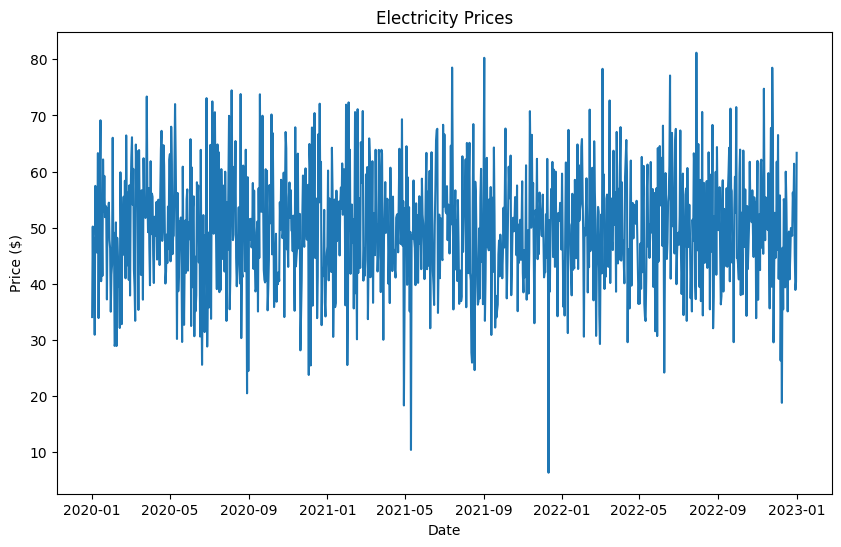

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Assuming the MAT file has been converted to CSV
data = pd.read_csv('sample_data/electricity_prices_corrected.csv')

# Convert dates from string to datetime format if not already in datetime
data['PriceDates'] = pd.to_datetime(data['PriceDates'])
data['FutExpiry'] = pd.to_datetime(data['FutExpiry'])
data['FutValuationDate'] = pd.to_datetime(data['FutValuationDate'])

# Plot the electricity prices
plt.figure(figsize=(10, 6))
plt.plot(data['PriceDates'], data['Prices'])
plt.title('Electricity Prices')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()

# Obtain the log of prices
data['logPrices'] = np.log(data['Prices'])

# Obtain the annual time factors from dates
# Assuming the yearfrac MATLAB function is equivalent to calculating the difference in years
price_dates = data['PriceDates']
start_date = price_dates.iloc[0]
data['PriceTimes'] = (price_dates - start_date).dt.days / 365.25




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure reproducibility
np.random.seed(0)

# Simulation parameters
nPeriods = 365 * 2 + 20
nTrials = 10000
dt = 1/365  # Assuming daily steps
lambda_val = 0.1  # Placeholder, replace with actual lambda value from calibration
alpha = 0.05  # Placeholder, replace with actual alpha value
kappa = 0.03  # Placeholder, replace with actual kappa value
sigma = 0.2  # Placeholder, replace with actual sigma value
mu_J = -0.2  # Placeholder, replace with actual mu_J value
sigma_J = 0.1  # Placeholder, replace with actual sigma_J value

n1 = np.random.randn(nPeriods, nTrials)
n2 = np.random.randn(nPeriods, nTrials)
j = np.random.binomial(1, lambda_val*dt, (nPeriods, nTrials))
SimPrices = np.zeros((nPeriods, nTrials))
SimPrices[0, :] = 100  # Initial condition, replace 100 with the actual initial price

for i in range(1, nPeriods):
    SimPrices[i, :] = alpha*dt + (1 - kappa*dt)*SimPrices[i-1, :] + \
    sigma*np.sqrt(dt)*n1[i, :] + j[i, :]*(mu_J + sigma_J*n2[i, :])

# Add back seasonality (placeholder for seasonMatrix and seasonParam functionality)
# This will require the actual implementation of seasonMatrix and calculation of seasonParam

# Plotting only the first trial for simplicity
plt.figure(figsize=(10, 6))
plt.plot(SimPrices[:, 0])
plt.title('Simulated Electricity Prices')
plt.xlabel('Time Step')
plt.ylabel('Price ($)')
plt.show()


In [10]:
import numpy as np

# Assuming riskPremium has been calculated
# Placeholder for initial conditions and parameters
nPeriods = 730  # Example: 2 years of daily data
riskPremium = np.random.rand(nPeriods)  # Placeholder for actual risk premium values
alpha = 0.05  # Drift under the real-world measure
sigma = 0.2  # Volatility

# Adjusting drift for risk-neutral measure
alpha_rn = alpha - sigma * riskPremium

# This is a placeholder for the actual simulation process, which would involve
# generating price paths using the risk-neutral drift and other model parameters
